### MLP (Multi Layer Perceptron) Experiements

### Model Setup for Predicting A_CP
We aim to build a model that predicts the A_CP feature (current price of portfolio A) and evaluate its performance by comparing the loss of the predicted values against the actual values.</br>

#### Steps to Set Up the Model:</br>
Data Preparation:</br>
Load the dataset and split it into training, validation, and test sets.</br>
Normalize the features to ensure that all features contribute equally to the model training.</br>

Define the Model:</br>
Use a simple Multi-Layer Perceptron (MLP) as the model architecture.</br>
The model will consist of input, hidden, and output layers with ReLU activation functions.</br>

Training the Model:</br>
Define the loss function (Mean Squared Error) and the optimizer (Adam).</br>
Train the model on the training set and validate it on the validation set.</br>
Monitor the loss to ensure the model is learning properly.</br>

Evaluating the Model:</br>
Evaluate the model on the test set.</br>
Compare the predicted A_CP values with the actual A_CP values using the loss function.</br>


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

### Feature Descriptions

- **DATE**: Represents the date when the financial data was collected.
- **FFR**: Represents the Federal Funds Rate (the interest rate at which depository institutions trade federal funds with each other overnight in the U.S.).
- **BOK**: Represents the interest rate set by the Bank of Korea.
- **TB3Y, TB10Y**: Represents the yields on 3-year and 10-year U.S. Treasury Bonds, respectively.
- **CD**: Represents the Certificate of Deposit rate.
- **USD**: Represents the exchange rate for the U.S. dollar.
- **A_SP, B_SP, C_SP, D_SP, E_SP, F_SP, G_SP**: Represents the stock prices of portfolios (or stocks) A to G.
- **A_CP, B_CP, C_CP, D_CP, E_CP, F_CP, G_CP**: Represents the current prices of portfolios A to G.
- **A_AUM, B_AUM, C_AUM, D_AUM, E_AUM, F_AUM, G_AUM**: Represents the Assets Under Management (AUM) for portfolios A to G.
- **A_VOL, B_VOL, C_VOL, D_VOL, E_VOL, F_VOL, G_VOL**: Represents the trading volume for portfolios A to G.
- **A_NAV, B_NAV, C_NAV, D_NAV, E_NAV, F_NAV, G_NAV**: Represents the Net Asset Value (NAV) for portfolios A to G.


In [2]:
# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
## Fixing numerics
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [120]:
## data preprocessing
data = pd.read_csv('./data.csv')
data = data.set_index('DATE')
data = data.sort_index()
data = data.replace(to_replace=',', value='', regex=True)
data = data.astype(float)
data['target'] = data.A_CP.shift(-1)
data = data.dropna()
data

,FFR,BOK,TB3Y,TB10Y,CD,USD,A_SP,A_CP,A_AUM,A_VOL,...,F_CP,F_AUM,F_VOL,F_NAV,G_SP,G_CP,G_AUM,G_VOL,G_NAV,target
DATE,,,,,,,,,,,,,,,,,,,,,
2018-05-11,1.75,1.5,2.282,2.785,1.65,1075.3,100655.0,100655.0,1163069.0,66618.0,...,31865.0,5770752.0,7231864.0,31913.84,6085.0,6075.0,663390.0,4286144.0,6103.90,100660.0
2018-05-14,1.75,1.5,2.305,2.792,1.65,1068.6,100655.0,100660.0,1170474.0,9902.0,...,31800.0,5603160.0,5904625.0,31834.53,6065.0,6090.0,661374.0,2517386.0,6118.88,100660.0
2018-05-15,1.75,1.5,2.308,2.815,1.65,1066.6,100660.0,100660.0,1171884.0,19864.0,...,31510.0,5501646.0,5743855.0,31555.82,6095.0,6145.0,665504.0,4043920.0,6178.30,100670.0
2018-05-16,1.75,1.5,2.278,2.782,1.65,1072.6,100665.0,100670.0,1172604.0,13733.0,...,31610.0,5659771.0,6580601.0,31657.98,6175.0,6120.0,662796.0,5805785.0,6156.20,100690.0
2018-05-17,1.75,1.5,2.265,2.797,1.65,1078.7,100690.0,100690.0,1182906.0,10933.0,...,31495.0,5623432.0,4361954.0,31489.75,6105.0,6170.0,668211.0,5476774.0,6185.40,100700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,5.50,3.5,3.415,3.507,3.60,1364.5,109690.0,109700.0,732138.0,80547.0,...,36685.0,6498748.0,5643266.0,36757.53,4195.0,4210.0,645814.0,26027026.0,4206.62,109705.0
2024-05-27,5.50,3.5,3.410,3.497,3.61,1370.0,109695.0,109705.0,732171.0,7600.0,...,37195.0,6529582.0,6649585.0,37265.83,4190.0,4150.0,644080.0,38208337.0,4147.19,109720.0
2024-05-28,5.50,3.5,3.387,3.477,3.62,1365.4,109720.0,109720.0,732271.0,20970.0,...,37235.0,6452826.0,4056913.0,37285.83,4160.0,4140.0,635490.0,20611692.0,4144.17,109720.0


In [121]:
train = data.iloc[:800]
valid = data.iloc[800:800+400] 
test = data.iloc[800+400:]

In [122]:
standard_scaler = StandardScaler()

In [123]:
# if we use only train, not train.iloc[], we would loose the structure of dataframe like index, columns.
train.iloc[:] = standard_scaler.fit_transform(train)
valid.iloc[:] = standard_scaler.transform(valid)
test.iloc[:] = standard_scaler.transform(test)

### Dataset structure (Class)

In [124]:
## Dataset structure (Class)
class StockDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data.iloc[index, :-1]
        y = self.data.iloc[index, -1:]

        x = torch.Tensor(x)
        y = torch.Tensor(y)

        return {
            'X': x,
            'y': y,
        }

In [125]:
len(valid)

400

In [126]:
train_dataset = StockDataset(train)
valid_dataset = StockDataset(valid)
test_dataset = StockDataset(test)

### Hyperparameter configuration

Hyperparameters: Values ​​that must be set directly by the user
 - batch_size: Out of all data, data will be divided into batches. Set how many batches to split into.
 - epoch: How many learning sessions will be conducted
 - learning_rate: How long will the learning take?

In [127]:
batch_size = 128
epochs = 50
learning_rate = 1e-3
hidden_dim = 64

### Data Loader
Used when iterating a dataset
Each iteration returns a batch of features and labels of batch_size.

In [128]:
## Data Loader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle = False,
    drop_last=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    drop_last = True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    drop_last = True
)

### Define Model Architecture 

- Define the model architecture to be used during training
- If the number of data is small compared to model complexity, overfitting is likely to occur.
- If the number of data is large compared to model complexity, underfitting is likely to occur.

In [129]:
### Define Model Architecture 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) ## fully-connected layer (1st)
        self.relu = nn.ReLU() ## activation function for non-linearity
        self.fc2 = nn.Linear(hidden_dim, output_dim) ## fully-connected layer (2nd)

    def forward(self, x): # forward propagation
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

### Define model

In [130]:
# len(train.coloums)-1, to except target column at the last
model = MLP(len(train.columns)-1, hidden_dim, 1) ##input_dim, hidden_dim, output_dim 

### Configure Loss fuction 

In [131]:
criterion = nn.MSELoss().to(device)

### Configure Optimizer 
Define optimal algorithm to train (Adam) 

In [132]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [133]:
train_losses = []
valid_losses = []
stop_count = 0
val_loss_best = np.inf

for epoch in range(1, epochs+1):
    ### train ###
    total_train_loss = 0
    for batch in train_dataloader:
        X = batch.get('X').to(device)
        y = batch.get('y').to(device)

        optimizer.zero_grad()
        output = model(X)
        train_loss = criterion(output, y)
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss
    
    train_losses.append(total_train_loss.item())

    ### valid ###
    total_valid_loss = 0
    model.eval()
    for batch in valid_dataloader:
        X = batch.get('X').to(device)
        y = batch.get('y').to(device)

        output = model(X)
        valid_loss = criterion(output, y)

        total_valid_loss += valid_loss

    valid_losses.append(total_valid_loss.item())

    ### early stop ###
    if val_loss_best > total_valid_loss:
        val_loss_best = total_valid_loss

        stop_count = 0

    else:
        stop_count += 1
    
    if stop_count > 5:
        break

    print(f'Epoch: {epoch: 3d} | train_loss: {np.mean(train_losses): .6f} | valid_loss: {np.mean(valid_losses): .6f}')



/var/folders/x6/29gj9fhd1rs_98l6pyr3bngw0000gn/T/ipykernel_40698/2862007400.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.Tensor(x)
/var/folders/x6/29gj9fhd1rs_98l6pyr3bngw0000gn/T/ipykernel_40698/2862007400.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.Tensor(y)


Epoch:   1 | train_loss:  5.717977 | valid_loss:  629.845276
Epoch:   2 | train_loss:  4.667722 | valid_loss:  659.428101
Epoch:   3 | train_loss:  3.891316 | valid_loss:  679.542053
Epoch:   4 | train_loss:  3.308689 | valid_loss:  686.214127
Epoch:   5 | train_loss:  2.876133 | valid_loss:  678.698132
Epoch:   6 | train_loss:  2.554555 | valid_loss:  658.342784
Epoch:   7 | train_loss:  2.309238 | valid_loss:  628.484480
Epoch:   8 | train_loss:  2.114630 | valid_loss:  593.154568
Epoch:   9 | train_loss:  1.955046 | valid_loss:  556.162262
Epoch:  10 | train_loss:  1.821381 | valid_loss:  520.315207
Epoch:  11 | train_loss:  1.707701 | valid_loss:  487.120139
Epoch:  12 | train_loss:  1.609600 | valid_loss:  457.161207
Epoch:  13 | train_loss:  1.523741 | valid_loss:  430.464536
Epoch:  14 | train_loss:  1.447674 | valid_loss:  406.760449
Epoch:  15 | train_loss:  1.379618 | valid_loss:  385.671330
Epoch:  16 | train_loss:  1.318233 | valid_loss:  366.816269
Epoch:  17 | train_loss:

### Test 
- Evaluate performance of used model from training
- Comparision between the accuracy of train and test cases
- eval()

In [134]:
y_test = []
model.eval()
for batch in test_dataloader:
    X = batch.get("X").to(device)
    y = batch.get("y").to(device)

    output = model(X)

    y_test.extend(output.detach())

/var/folders/x6/29gj9fhd1rs_98l6pyr3bngw0000gn/T/ipykernel_40698/2862007400.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.Tensor(x)
/var/folders/x6/29gj9fhd1rs_98l6pyr3bngw0000gn/T/ipykernel_40698/2862007400.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.Tensor(y)


In [135]:
np.where(data.columns == 'A_CP')

(array([7]),)

<Axes: xlabel='DATE'>

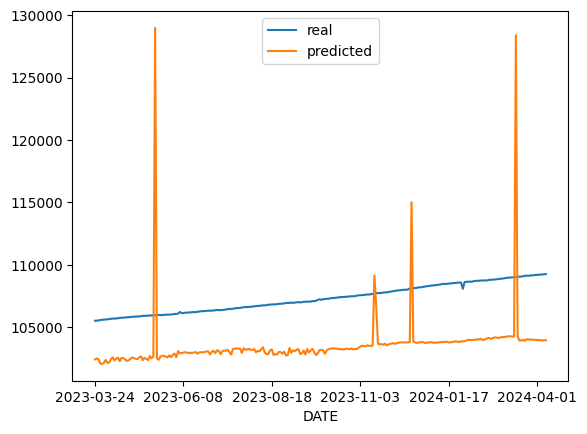

In [136]:
pd.DataFrame({
    'real': test.iloc[:-(len(test)-256), -1]*standard_scaler.scale_[7] + standard_scaler.mean_[7],
    'predicted': (torch.concat(y_test)*standard_scaler.scale_[7] + standard_scaler.mean_[7]).numpy()
}).plot()